In [1]:
import numpy as np

import pandas as pd
import time
import matplotlib.pyplot as plt
import re, string, timeit

from nltk.tag.stanford import StanfordNERTagger
import pickle

In [2]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC

from tqdm import tqdm
import stanza

In [3]:
import os
java_path = "C:/Program Files/Java/jre1.8.0_191/bin/java.exe"
os.environ['JAVAHOME'] = java_path


In [4]:
df = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)
print(df.shape)
#pd.set_option('display.max_colwidth', None)
df.head()

(200853, 6)


,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


<BarContainer object of 41 artists>

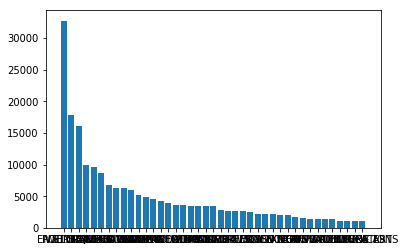

In [5]:
summary = df[['category','headline']].groupby('category', as_index = False).count().sort_values ('headline', ascending = False)
plt.bar(summary['category'], summary['headline'])

In [6]:
summary.sort_values ('headline', ascending = False)

,category,headline
24,POLITICS,32739
37,WELLNESS,17827
10,ENTERTAINMENT,16058
34,TRAVEL,9887
30,STYLE & BEAUTY,9649
22,PARENTING,8677
16,HEALTHY LIVING,6694
25,QUEER VOICES,6314
13,FOOD & DRINK,6226
3,BUSINESS,5937


In [7]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [8]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

In [34]:
#NER TAGGER, also removes adjacent duplicating entities

# Add the jar and model via their path (instead of setting environment variables):
#jar = 'E:/Python/stanford-ner-4.2.0/stanford-ner-2020-11-17/stanford-ner.jar'
#model = 'E:/Python/stanford-ner-4.2.0/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz'
#pos_tagger = StanfordNERTagger(model, jar, encoding='utf8')
nlp = stanza.Pipeline('en',processors='tokenize,ner')
'''def NER(phrase):
    NER1 = [i[1] if i[1]!= 'O' else i[0] for i in pos_tagger.tag(phrase.split()) ]
    result = []
    for x, words in enumerate(NER1):
        if x == 0:
            result.append(words)
        else:
            if NER1[x] != NER1[x-1]:
                result.append(words)
    return " ".join(result)'''


def NER(phrase):
    NEREntity = [token.ner[2:] if token.ner != 'O' else token.text for i, sentence in enumerate(nlp(phrase).sentences) for token in sentence.tokens]
    result = []
    for x, words in enumerate(NEREntity):
        if x == 0:
            result.append(words)
        else:
            if NEREntity[x] != NEREntity[x-1]:
                result.append(words)
    return " ".join(result)

def preprocessing(text, NERYN):
  remove_punc = ' '.join(word.strip(string.punctuation) for word in text.split())
  #clean_text = [wn.lemmatize(words.lower(), pos="v") for words in word_tokenize(remove_punc) if (words not in stop_words_)]
  if NERYN:
    return " ".join([word for word in word_tokenize(NER(remove_punc))])
  else:
      return " ".join([word for word in word_tokenize(remove_punc)])


#testing feature preprocessing
testingtext = df['short_description'][5]
print('Original text: ', testingtext)
print('Remove Punctuation: ', ' '.join(word.strip(string.punctuation) for word in testingtext.split()))
print('NER TAGGER text: ', " ".join([token.ner[2:] if token.ner != 'O' else token.text for i, sentence in enumerate(nlp(testingtext).sentences) for token in sentence.tokens]))
print('NER tagger without adjacent duplicating Entities: ', NER(testingtext))
print('Final Output: ', preprocessing(testingtext, True))

2021-07-31 17:02:17 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-07-31 17:02:17 INFO: Use device: cpu
2021-07-31 17:02:17 INFO: Loading: tokenize
2021-07-31 17:02:17 INFO: Loading: ner
2021-07-31 17:02:18 INFO: Done loading processors!


Original text:  "It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor," he said in a statement.
Remove Punctuation:  It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor he said in a statement
NER TAGGER text:  " It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor , " he said in a statement .
NER tagger without adjacent duplicating Entities:  " It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor , " he said in a statement .
Final Output:  It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor he said in a statement


In [10]:
sentence = "At eight o'clock on Thursday morning, Arthur didn't feel very good."

In [11]:
preprocessing(sentence)

"At TIME on TIME PERSON did n't feel very good"

In [35]:

le = LabelEncoder()
def processingAll(df, NERYN):
    df['category'] = le.fit_transform(df['category'])
    processed_df = []
    for text in tqdm(df[['headline', 'short_description']].apply(lambda x: ' '.join(x), axis=1)):
        processed_df.append(preprocessing(text, NERYN))
    df['text'] = processed_df
    print('Total Processed: ', df.shape[0])
    return df

In [15]:
processed_df = processingAll(df.iloc[:100000], True)
processed_df.to_pickle('data/processedDF0-100000.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
100%|██████████| 100000/100000 [9:40:51<00:00,  3.13it/s]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Total Processed:  100000


In [20]:
processed_df2 = processingAll(df.iloc[100000:], True)
processed_df2.to_pickle('data/processedDF100000-max.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
100%|██████████| 100853/100853 [9:22:19<00:00,  3.52it/s]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Total Processed:  100853


In [21]:
processedDF0 = pd.read_pickle('data/processedDF0-100000.pkl')
processedDF1 = pd.read_pickle('data/processedDF100000-max.pkl')

In [24]:
processed_final = pd.concat([processedDF0, processedDF1])

In [30]:
processed_final = processed_final.rename(columns={'text': 'NERtext'})

In [37]:
processed_final2 = processingAll(processed_final, False)

100%|██████████| 200853/200853 [00:41<00:00, 4854.92it/s]


Total Processed:  200853


In [39]:
for i in processed_final2.head()['NERtext']:
    print(i)

There Were CARDINAL Mass Shootings In GPE DATE But DATE On TV She left her husband He killed their children Just another day in GPE
Will Smith Joins Diplo And PERSON For WORK_OF_ART Of course it has a song
PERSON For The ORDINAL Time At DATE The actor and his longtime girlfriend PERSON tied the knot in a civil ceremony
PERSON Blasts GPE PERSON And NORP In New Artwork The actor gives NORP an ass-kicking for not fighting hard enough against PERSON
PERSON Uses PERSON Poop Bags To Pick Up After Her Dog The NORP actress said using the bags is a really cathartic therapeutic moment


In [52]:
processed_final2 = processed_final2.join(df[['category']], lsuffix = '_NER')

In [55]:
processed_final2 = processed_final2.drop('category_NER', axis = 1)

In [56]:
processed_final2.to_pickle('data/final_Processed_df.pkl')